In [77]:
suppressMessages(library(survminer))
suppressMessages(library(survival))
suppressMessages(library(forestplot))
suppressMessages(library(ggsci))
suppressMessages(library(dplyr))
suppressMessages(library(adjustedCurves))
suppressMessages(library(tidyverse))
suppressMessages(library(cmprsk))
suppressMessages(library(caret))

## 0. Funcs
---

In [132]:
getCoef <- function(mod){
    df <- data.frame(summary(mod)$coef)
    df$coef_exp <- signif(exp(df$coef),3)
    df$ci_lower <- signif(exp(df$coef - 1.96 * df$se.coef.),3)
    df$ci_upper <- signif(exp(df$coef + 1.96 * df$se.coef.),3)
    df$HR <- paste(df$coef_exp, " (", df$ci_lower, "-", df$ci_upper, ")", sep="")
    return(data.frame(df))
}

coxSummary <- function(cox_models, var, filt=TRUE){
    i <- 1
    result_list = list()

    for (i in seq_along(cox_models)) {
        formula <- Reduce(paste,deparse(formula(cox_models[[i]])))
        hazard_ratios <- getCoef(cox_models[[i]])$HR
        names(hazard_ratios) <- rownames(getCoef(cox_models[[i]]))

        if (filt==T){
            hazard_ratios <- hazard_ratios[names(hazard_ratios)[grepl(paste0("^", var), names(hazard_ratios))]]
            names(hazard_ratios) <- sub(paste0("^", var), "", names(hazard_ratios))
        }

        df <- data.frame(rbind(hazard_ratios))
        df$Model <- as.character(formula)
        result_list[[i]] <- df
    }
    # Combine all dataframes into one
    results_df <- do.call(rbind, result_list)
    rownames(results_df) <- results_df$Model
    results_df$Model <- NULL

    # Return the dataframe
    return(results_df)

}

getRiskDiff <- function(clust.adjsurv, groupings, times.to.use=c(1,5,10)){
    # Risk Difference Table
    clust.adjci <- clust.adjsurv
    clust.adjci$adjsurv$surv <- 1-clust.adjci$adjsurv$surv

    # Define the desired order of the groups
    order <- groupings

    # Print the reordered dataframe
    result_list = list()

    # For each grouping
    for (i in seq_along(groupings)){
        group_1 = str_split(groupings[[i]], " vs. ")[[1]][1]
        group_2 = str_split(groupings[[i]], " vs. ")[[1]][2]
        result_list[[i]] <- adjusted_curve_diff(clust.adjci, times=times.to.use, group_1=group_1, group_2=group_2, conf_int=TRUE)
        result_list[[i]]$group <- groupings[[i]]
    }

    cd.df <- do.call(rbind, result_list)

    # Percentage
    cd.df$diff <- signif(cd.df$diff*100,3)
    cd.df$ci_lower <- signif(cd.df$ci_lower*100,3)
    cd.df$ci_upper <- signif(cd.df$ci_upper*100,3)
    cd.df$RD <- paste(cd.df$diff, " (", cd.df$ci_lower, "-", cd.df$ci_upper, ")", sep="")
    
    r <- spread(cd.df[,c("time","RD","group")], key = time, value = RD) %>% 
        mutate(group = factor(group, levels = order)) %>%
        arrange(group)

    return(r)
}

getIncidenceGroup <- function(clust.adjsurv, times.to.use=c(1,5,10)){
  clust.adjci <- clust.adjsurv
  clust.adjci$adjsurv$surv <- 1-clust.adjci$adjsurv$surv

  # CI Difference Table
  closest_rows <- list()

  for (i in seq_along(times.to.use)){
    closest_rows[i] <- clust.adjsurv$boot_adjsurv[which.min(abs(clust.adjsurv$boot_adjsurv$time - times.to.use[[i]])), "time"]
  }
  ci.df <- clust.adjsurv$boot_adjsurv[clust.adjsurv$boot_adjsurv$time %in% closest_rows,]
  ci.df$boot_surv <- signif((1-ci.df$boot_surv)*100,3)
  ci.df$ci_upper <- signif((1-ci.df$ci_upper)*100,3)
  ci.df$ci_lower <- signif((1-ci.df$ci_lower)*100,3)
  ci.df$CI <- paste(ci.df$boot_surv, " (", ci.df$ci_lower, "-", ci.df$ci_upper, ")", sep="")

  result.df <- spread(ci.df[,c("time","CI","group")], key = time, value = CI) %>% 
    mutate(group = factor(group)) %>%
    arrange(group)
  
  rownames(result.df) <- result.df$group
  result.df$group <- NULL
  colnames(result.df) <- times.to.use
  return(result.df)
}

getDummy <- function(df, vars){
    dmy <- dummyVars(" ~ .", data = df[,vars,drop=F], fullRank=TRUE)
    cov <- data.frame(predict(dmy, newdata = df[,vars,drop=F]))
    return(cov)
}

## 1. Load Dataset
---

In [3]:
data.df <- read.table("data/processed/AL_with_ccp_03.tsv", sep="\t", header=T, row.names='Code.ID')

# Rename columns
column_mapping <- c("LC.Isotype"="Kappa_or_lambda_PCD", 
                    "BU.Cardiac.Stage"="BU__BNP_based__cardiac_staging",
                    "BMPC.%"="Bone_marrow_plasma_cells____"
                   )

data.df <- data.df %>% rename(!!!column_mapping)

# Filter for time from admission >=0
data.df <- data.df[data.df$time_from_admission>=0,]

# Collapse Race
data.df <- data.df %>%
   mutate(Race = ifelse(Race %in% c('American_Indian_Alaska_Native','Multiracial','Native_Hawaiian_Pacific', 'Unknown/other'), 'Other', Race))

# Fix NULL values
data.df <- data.df %>% mutate(BU.Cardiac.Stage = ifelse(BU.Cardiac.Stage=="", NA, BU.Cardiac.Stage))
data.df <- data.df %>% mutate(Primary_organ = ifelse(Primary_organ=="", NA, Primary_organ))
data.df <- data.df %>% mutate(LC.Isotype = ifelse(LC.Isotype=="", NA, LC.Isotype))

# assign cluster to var
data.df$m02q3_cluster_n <- factor(data.df$m02q3_cluster_n, levels=c("Low","Intermediate","High"))
data.df <- data.df[complete.cases(data.df[,"m02q3_cluster_n"]),]
data.df$m02q4_cluster_n <- factor(data.df$m02q4_cluster_n, levels=c("Low","Intermediate-Low","Intermediate","High"))
data.df$fna3_cluster_n <- factor(data.df$fna3_cluster_n, levels=c("Low","Intermediate","High"))
data.df$BU.Cardiac.Stage <- as.factor(data.df$BU.Cardiac.Stage)

# As Factor
data.df$LC.Isotype <- as.factor(data.df$LC.Isotype)
data.df$Sex <- as.factor(data.df$Sex)
data.df$Race <- as.factor(data.df$Race)
data.df$Era <- as.factor(data.df$Era)

In [4]:
# Load ESKD Data
eskd.df <- read.table("data/processed/treatment_eskd.tsv", sep="\t", header=T, row.names="Code.ID")
eskd.df <- eskd.df[rownames(data.df),]
eskd.df <- cbind(data.df, eskd.df[,c("RRT.Type","treatment_eskd","time_to_eskd","time_to_eskd_from_admission","CR_event","CR_time")])
eskd.df <- eskd.df[complete.cases(eskd.df$time_to_eskd),]

# Filter for whether or not patients had ESKD at baseline
eskd.df <- eskd.df[eskd.df$time_to_eskd>0,]

## 2. Cox Regression Modeling
---

In [5]:
# Baseline Model
eskd.crude <- coxph(Surv(time_to_eskd, treatment_eskd) ~ fna3_cluster_n, data=eskd.df)
eskd.baseline <- coxph(Surv(time_to_eskd, treatment_eskd) ~ Age + Sex + Race + LC.Isotype, data=eskd.df)
cox.zph(eskd.baseline)

            chisq df      p
Age         0.552  1 0.4575
Sex         0.290  1 0.5904
Race        2.039  3 0.5644
LC.Isotype  9.011  1 0.0027
GLOBAL     12.495  6 0.0518

In [6]:
# Baseline Model stratified
eskd.baseline.t <- coxph(Surv(time_to_eskd, treatment_eskd) ~ Age + Sex + Race + strata(LC.Isotype), data=eskd.df)
eskd.baseline.cluster.t <- coxph(Surv(time_to_eskd, treatment_eskd) ~ fna3_cluster_n + Age + Sex + Race + strata(LC.Isotype), data=eskd.df, x=TRUE)

In [7]:
# Model w/ Labs
eskd.labs <- coxph(Surv(time_to_eskd, treatment_eskd) ~ Age + Sex + Race + eGFR + log2(X24_hr_UTP+1) + strata(LC.Isotype), data=eskd.df)
cox.zph(eskd.labs)

                      chisq df       p
Age                   2.607  1   0.106
Sex                   0.355  1   0.551
Race                  1.809  3   0.613
eGFR                 36.809  1 1.3e-09
log2(X24_hr_UTP + 1)  3.601  1   0.058
GLOBAL               44.571  7 1.7e-07

In [8]:
# Model w/ Labs
# Adjusted by eGFR for time
eskd.labs.t <- coxph(Surv(time_to_eskd, treatment_eskd) ~ Age + Sex + Race + eGFR + tt(eGFR) +
    log2(X24_hr_UTP+1) + strata(LC.Isotype), 
    data=eskd.df[complete.cases(eskd.df$eGFR),], 
    tt=function(x,t,...) x * log(t))
summary(eskd.labs.t)

Call:
coxph(formula = Surv(time_to_eskd, treatment_eskd) ~ Age + Sex + 
    Race + eGFR + tt(eGFR) + log2(X24_hr_UTP + 1) + strata(LC.Isotype), 
    data = eskd.df[complete.cases(eskd.df$eGFR), ], tt = function(x, 
        t, ...) x * log(t))

  n= 1707, number of events= 252 
   (154 observations deleted due to missingness)

                          coef exp(coef)  se(coef)       z Pr(>|z|)    
Age                  -0.019487  0.980701  0.006286  -3.100  0.00193 ** 
Sexmale               0.092343  1.096741  0.132434   0.697  0.48563    
RaceBlack             0.193799  1.213852  0.570951   0.339  0.73428    
RaceOther             0.868130  2.382452  0.877749   0.989  0.32264    
RaceWhite             0.598009  1.818494  0.507634   1.178  0.23878    
eGFR                 -0.044074  0.956883  0.003356 -13.132  < 2e-16 ***
tt(eGFR)              0.014385  1.014489  0.002109   6.822 8.97e-12 ***
log2(X24_hr_UTP + 1)  0.026861  1.027225  0.015487   1.734  0.08284 .  
---
Signif. codes:  0 '*

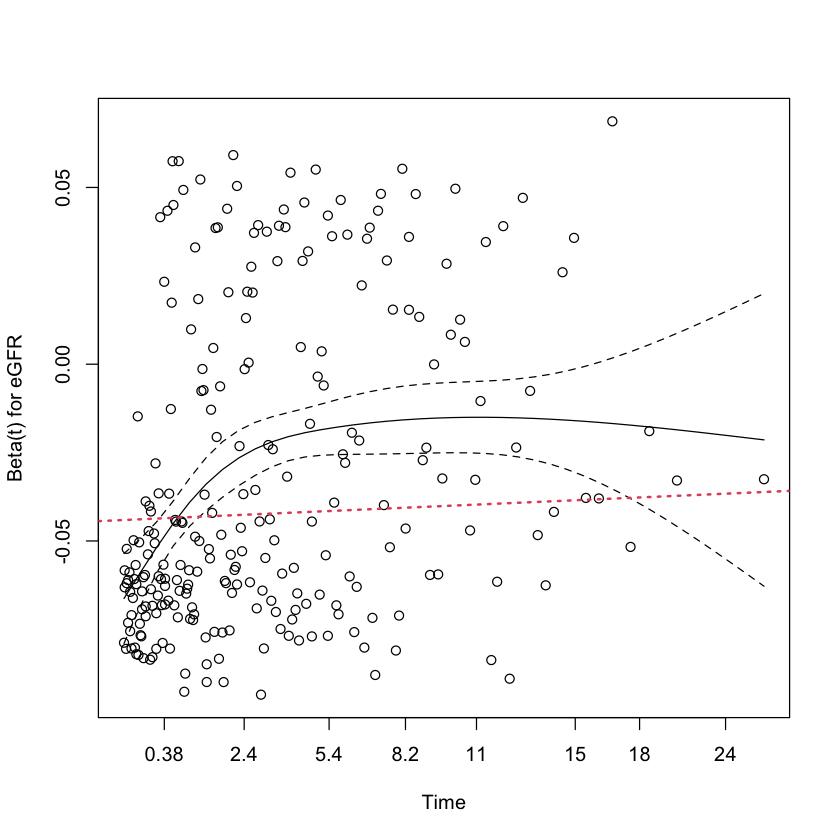

In [9]:
plot(cox.zph(eskd.labs)[4])
abline(coef(eskd.labs.t)[6:7], lwd=2, lty=3, col=2)

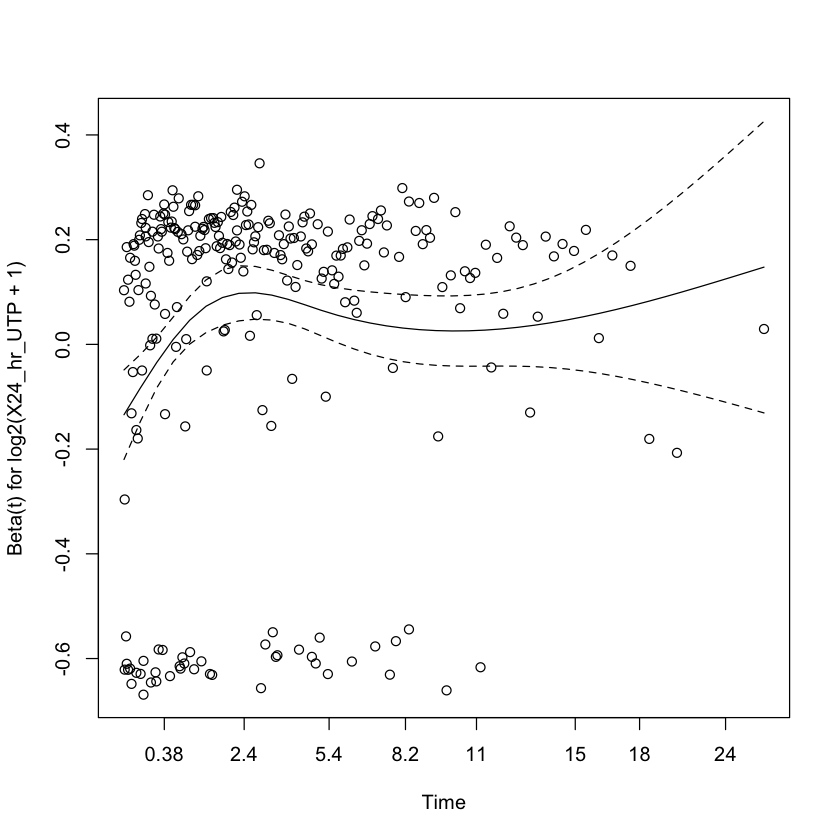

In [10]:
plot(cox.zph(eskd.labs)[5])

In [11]:
# Model w/ Labs
# Adjusted by eGFR for time
eskd.labs.cluster.t <- coxph(Surv(time_to_eskd, treatment_eskd) ~ fna3_cluster_n + Age + Sex + Race + eGFR + tt(eGFR) +
    log2(X24_hr_UTP+1) + strata(LC.Isotype), 
    data=eskd.df, 
    tt=function(x,t,...) x * log(t))
summary(eskd.labs.cluster.t)

Call:
coxph(formula = Surv(time_to_eskd, treatment_eskd) ~ fna3_cluster_n + 
    Age + Sex + Race + eGFR + tt(eGFR) + log2(X24_hr_UTP + 1) + 
    strata(LC.Isotype), data = eskd.df, tt = function(x, t, ...) x * 
    log(t))

  n= 1701, number of events= 251 
   (339 observations deleted due to missingness)

                                coef exp(coef)  se(coef)       z Pr(>|z|)    
fna3_cluster_nIntermediate  0.626794  1.871600  0.142531   4.398 1.09e-05 ***
fna3_cluster_nHigh         -0.641274  0.526621  0.336195  -1.907 0.056462 .  
Age                        -0.020409  0.979798  0.006154  -3.316 0.000912 ***
Sexmale                     0.119850  1.127328  0.133608   0.897 0.369702    
RaceBlack                   0.272240  1.312902  0.571638   0.476 0.633900    
RaceOther                   0.679222  1.972343  0.877365   0.774 0.438835    
RaceWhite                   0.625679  1.869515  0.508225   1.231 0.218284    
eGFR                       -0.042791  0.958112  0.003335 -12.831  <

In [12]:
# Model w/ Labs
# Adjusted by eGFR for time
eskd.labs.stage.t <- coxph(Surv(time_to_eskd, treatment_eskd) ~ Renal.Stage..Palladini. + Age + Sex + Race + eGFR + tt(eGFR) +
    log2(X24_hr_UTP+1) + strata(LC.Isotype), 
    data=eskd.df, 
    tt=function(x,t,...) x * log(t))
summary(eskd.labs.stage.t)

Call:
coxph(formula = Surv(time_to_eskd, treatment_eskd) ~ Renal.Stage..Palladini. + 
    Age + Sex + Race + eGFR + tt(eGFR) + log2(X24_hr_UTP + 1) + 
    strata(LC.Isotype), data = eskd.df, tt = function(x, t, ...) x * 
    log(t))

  n= 1707, number of events= 252 
   (333 observations deleted due to missingness)

                                      coef exp(coef)  se(coef)      z Pr(>|z|)
Renal.Stage..Palladini.Stage II   1.476160  4.376110  0.253572  5.821 5.83e-09
Renal.Stage..Palladini.Stage III  1.740911  5.702534  0.333919  5.214 1.85e-07
Age                              -0.016385  0.983748  0.006282 -2.608   0.0091
Sexmale                           0.042077  1.042975  0.132963  0.316   0.7517
RaceBlack                         0.208720  1.232100  0.571482  0.365   0.7149
RaceOther                         0.832744  2.299620  0.882264  0.944   0.3452
RaceWhite                         0.619845  1.858640  0.507382  1.222   0.2218
eGFR                             -0.033430  0.9671

In [13]:
# Model w/ Labs
# Adjusted by eGFR for time
eskd.labs.stage.cluster.t <- coxph(Surv(time_to_eskd, treatment_eskd) ~ fna3_cluster_n + Renal.Stage..Palladini. + Age + Sex + Race + eGFR + tt(eGFR) +
    log2(X24_hr_UTP+1) + strata(LC.Isotype), 
    data=eskd.df, 
    tt=function(x,t,...) x * log(t))

# Model w/ Labs
# Adjusted by eGFR for time
# Add albumin
eskd.labs.stage.cluster.v2.t <- coxph(Surv(time_to_eskd, treatment_eskd) ~ fna3_cluster_n + Renal.Stage..Palladini. + Age + Sex + Race + eGFR + tt(eGFR) +
    log2(X24_hr_UTP+1) + Albumin + strata(LC.Isotype), 
    data=eskd.df, 
    tt=function(x,t,...) x * log(t))

In [258]:
cox_models <- list(eskd.crude, eskd.baseline.cluster.t, eskd.labs.cluster.t, eskd.labs.stage.cluster.t, eskd.labs.stage.cluster.v2.t)
cox_summary <- coxSummary(cox_models, var="fna3_cluster_n")
cox_summary$Low <- "Reference"

# Add events
result <- eskd.df %>% 
    filter(!is.na(eval(fna3_cluster_n))) %>% 
    group_by(fna3_cluster_n) %>% 
    summarize(Events = sum(treatment_eskd)) %>%
    column_to_rownames(var = "fna3_cluster_n")

cox_summmary <- rbind(t(result), cox_summary)
cox_summmary

,Low,Intermediate,High
,<chr>,<chr>,<chr>
Events,125,155,16
"Surv(time_to_eskd, treatment_eskd) ~ fna3_cluster_n",Reference,1.74 (1.37-2.2),0.455 (0.27-0.766)
"Surv(time_to_eskd, treatment_eskd) ~ fna3_cluster_n + Age + Sex + Race + strata(LC.Isotype)",Reference,1.82 (1.43-2.31),0.459 (0.272-0.775)
"Surv(time_to_eskd, treatment_eskd) ~ fna3_cluster_n + Age + Sex + Race + eGFR + tt(eGFR) + log2(X24_hr_UTP + 1) + strata(LC.Isotype)",Reference,1.87 (1.42-2.47),0.527 (0.272-1.02)
"Surv(time_to_eskd, treatment_eskd) ~ fna3_cluster_n + Renal.Stage..Palladini. + Age + Sex + Race + eGFR + tt(eGFR) + log2(X24_hr_UTP + 1) + strata(LC.Isotype)",Reference,1.64 (1.22-2.21),0.651 (0.335-1.26)
"Surv(time_to_eskd, treatment_eskd) ~ fna3_cluster_n + Renal.Stage..Palladini. + Age + Sex + Race + eGFR + tt(eGFR) + log2(X24_hr_UTP + 1) + Albumin + strata(LC.Isotype)",Reference,1.22 (0.842-1.78),0.516 (0.236-1.13)


In [259]:
getCoef(eskd.labs.stage.cluster.t)

,coef,exp.coef.,se.coef.,z,Pr...z..,coef_exp,ci_lower,ci_upper,HR
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
fna3_cluster_nIntermediate,0.49675539,1.6433805,0.151157144,3.2863507,1.014946e-03,1.640,1.220,2.210,1.64 (1.22-2.21)
fna3_cluster_nHigh,-0.42964903,0.6507374,0.338248766,-1.2702161,2.040077e-01,0.651,0.335,1.260,0.651 (0.335-1.26)
Renal.Stage..Palladini.Stage II,1.22818577,3.4150283,0.259889401,4.7258017,2.292092e-06,3.420,2.050,5.680,3.42 (2.05-5.68)
Renal.Stage..Palladini.Stage III,1.29018954,3.6334752,0.352312547,3.6620596,2.501957e-04,3.630,1.820,7.250,3.63 (1.82-7.25)
Age,-0.01736880,0.9827812,0.006196178,-2.8031471,5.060659e-03,0.983,0.971,0.995,0.983 (0.971-0.995)
Sexmale,0.08226504,1.0857435,0.134137717,0.6132879,5.396860e-01,1.090,0.835,1.410,1.09 (0.835-1.41)
RaceBlack,0.24663848,1.2797164,0.572525350,0.4307905,6.666207e-01,1.280,0.417,3.930,1.28 (0.417-3.93)
RaceOther,0.72677344,2.0683960,0.881376715,0.8245889,4.096050e-01,2.070,0.368,11.600,2.07 (0.368-11.6)
RaceWhite,0.63298948,1.8832321,0.507870020,1.2463612,2.126318e-01,1.880,0.696,5.100,1.88 (0.696-5.1)


In [260]:
getCoef(eskd.labs.stage.cluster.v2.t)

,coef,exp.coef.,se.coef.,z,Pr...z..,coef_exp,ci_lower,ci_upper,HR
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
fna3_cluster_nIntermediate,0.20106609,1.2227056,0.190443840,1.0557763,2.910704e-01,1.220,0.842,1.780,1.22 (0.842-1.78)
fna3_cluster_nHigh,-0.66133546,0.5161616,0.398847542,-1.6581159,9.729407e-02,0.516,0.236,1.130,0.516 (0.236-1.13)
Renal.Stage..Palladini.Stage II,1.04482453,2.8428996,0.272112737,3.8396752,1.231972e-04,2.840,1.670,4.850,2.84 (1.67-4.85)
Renal.Stage..Palladini.Stage III,1.03792546,2.8233538,0.373648812,2.7778101,5.472659e-03,2.820,1.360,5.870,2.82 (1.36-5.87)
Age,-0.01783364,0.9823244,0.006522501,-2.7341712,6.253751e-03,0.982,0.970,0.995,0.982 (0.97-0.995)
Sexmale,0.06851996,1.0709220,0.141705152,0.4835389,6.287131e-01,1.070,0.811,1.410,1.07 (0.811-1.41)
RaceBlack,0.37816079,1.4595976,0.578701597,0.6534642,5.134570e-01,1.460,0.469,4.540,1.46 (0.469-4.54)
RaceOther,0.49869690,1.6465742,0.892513348,0.5587557,5.763285e-01,1.650,0.286,9.470,1.65 (0.286-9.47)
RaceWhite,0.63866720,1.8939549,0.509255546,1.2541193,2.097987e-01,1.890,0.698,5.140,1.89 (0.698-5.14)


## 3. Adjusted Cumulative Incidence of ESKD
---

In [16]:
summary(eskd.baseline.cluster.t)

Call:
coxph(formula = Surv(time_to_eskd, treatment_eskd) ~ fna3_cluster_n + 
    Age + Sex + Race + strata(LC.Isotype), data = eskd.df, x = TRUE)

  n= 2033, number of events= 296 
   (7 observations deleted due to missingness)

                                coef exp(coef)  se(coef)      z Pr(>|z|)    
fna3_cluster_nIntermediate  0.598233  1.818902  0.122574  4.881 1.06e-06 ***
fna3_cluster_nHigh         -0.779149  0.458796  0.267197 -2.916  0.00355 ** 
Age                        -0.010870  0.989189  0.005588 -1.945  0.05176 .  
Sexmale                     0.237757  1.268400  0.122148  1.946  0.05160 .  
RaceBlack                   0.328374  1.388708  0.503672  0.652  0.51443    
RaceOther                   1.051655  2.862386  0.731959  1.437  0.15078    
RaceWhite                   0.463690  1.589930  0.453052  1.023  0.30608    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

                           exp(coef) exp(-coef) lower .95 upper .95
fna3_cluster_nInter

In [17]:
# Adjusted survival curve without bootstrap
eskd.adjsurv <- adjustedsurv(data=eskd.df,
                        variable="fna3_cluster_n",
                        ev_time="time_to_eskd",
                        event="treatment_eskd",
                        method="direct",
                        outcome_model=eskd.baseline.cluster.t,
                        conf_int=T,
                        n_cores=8,
                        n_boot=1000,
                        bootstrap=TRUE
                       )

Loading required namespace: riskRegression

Warning message in .recacheSubclasses(def@className, def, env):
"undefined subclass "ndiMatrix" of class "replValueSp"; definition not updated"
Loading required namespace: doParallel



In [18]:
saveRDS(eskd.adjsurv, "data/analysis/eskd_adjsurv.rds")

In [21]:
pdf("figures/adjusted_eskd_clust.pdf")
plot(eskd.adjsurv, conf_int=TRUE, custom_colors=c("#62b67d","#69a9c8","#ca4a29"), cif=T) + xlim(0,12.5) + ylim(0,0.6)
dev.off()

Warning message:
"Removed 48 rows containing missing values (`geom_step()`)."


pdf 
  2

In [22]:
getIncidenceGroup(eskd.adjsurv)

,1,5,10
,<chr>,<chr>,<chr>
Low,5.01 (6.12-3.88),13.8 (16.4-11.5),23.6 (27.7-19.8)
Intermediate,8.9 (11-7.02),23.7 (27.6-19.7),38.6 (44.4-33.2)
High,2.35 (3.58-1.33),6.66 (9.95-3.87),11.7 (17-6.57)


In [23]:
getRiskDiff(eskd.adjsurv, c("Low vs. High","Intermediate vs. High","Intermediate vs. Low"))

group,1,5,10
<fct>,<chr>,<chr>,<chr>
Low vs. High,2.67 (1.05-4.3),7.21 (3.27-11.2),11.8 (5.31-18.4)
Intermediate vs. High,6.53 (4.31-8.76),17 (12-21.9),26.7 (19.2-34.3)
Intermediate vs. Low,3.86 (1.63-6.08),9.77 (5.2-14.3),14.9 (8.1-21.7)


In [24]:
# P-values
adj_test <- adjusted_curve_test(eskd.adjsurv, from=0, to=12)
summary(adj_test)

------------------------------------------------------------------
   Test of the Difference between two adjusted Survival Curves
------------------------------------------------------------------

Using the interval: 0 to 12 

                          ABC ABC SE 95% CI (lower) 95% CI (upper) P-Value
Low vs. Intermediate   1.2588 0.2639         0.7530         1.7527       0
Low vs. High          -0.9647 0.2568        -1.4533        -0.4740       0
Intermediate vs. High -2.2235 0.2946        -2.7759        -1.6224       0
                      N Boot
Low vs. Intermediate    1000
Low vs. High            1000
Intermediate vs. High   1000
------------------------------------------------------------------


In [28]:
clust.adjci <- eskd.adjsurv
clust.adjci$adjsurv$surv <- 1-clust.adjci$adjsurv$surv

In [30]:
pdf("figures/adjusted_eskd_clustdiff_low_high.pdf")
plot_curve_diff(clust.adjci, group_1="Low", group_2="High", conf_int=TRUE, color="blue") + ylim(0,0.4) + xlim(0,12.5)
dev.off()

Warning message:
"Removed 16 rows containing missing values (`geom_step()`)."


pdf 
  2

In [31]:
pdf("figures/adjusted_eskd_clustdiff_intermediate_high.pdf")
plot_curve_diff(clust.adjci, group_1="Intermediate", group_2="High", conf_int=TRUE, color="red")+ ylim(0,0.4) + xlim(0,12.5)
dev.off()

Warning message:
"Removed 16 rows containing missing values (`geom_step()`)."


pdf 
  2

In [32]:
pdf("figures/adjusted_eskd_clustdiff_high_intermediate.pdf")
plot_curve_diff(clust.adjci, group_1="Intermediate", group_2="Low", conf_int=TRUE, color="green")+ ylim(0,0.4) + xlim(0,12.5)
dev.off()

Warning message:
"Removed 16 rows containing missing values (`geom_step()`)."


pdf 
  2

## 4. Fine Gray Model
---

In [78]:
eskd.baseline.cluster.t

Call:
coxph(formula = Surv(time_to_eskd, treatment_eskd) ~ fna3_cluster_n + 
    Age + Sex + Race + strata(LC.Isotype), data = eskd.df, x = TRUE)

                                coef exp(coef)  se(coef)      z        p
fna3_cluster_nIntermediate  0.598233  1.818902  0.122574  4.881 1.06e-06
fna3_cluster_nHigh         -0.779149  0.458796  0.267197 -2.916  0.00355
Age                        -0.010870  0.989189  0.005588 -1.945  0.05176
Sexmale                     0.237757  1.268400  0.122148  1.946  0.05160
RaceBlack                   0.328374  1.388708  0.503672  0.652  0.51443
RaceOther                   1.051655  2.862386  0.731959  1.437  0.15078
RaceWhite                   0.463690  1.589930  0.453052  1.023  0.30608

Likelihood ratio test=58.08  on 7 df, p=3.646e-10
n= 2033, number of events= 296 
   (7 observations deleted due to missingness)

In [133]:
runFineGray <- function(df, covariates){
    cov1 <- getDummy(df, covariates)

    eskd.crr <- crr(ftime=df$CR_time, fstatus=df$CR_event, cov1=cov1, failcode=1, cencode=0)
    death.crr <- crr(ftime=df$CR_time, fstatus=df$CR_event, cov1=cov1, failcode=2, cencode=0)

    dcr.df <- getCoef(death.crr)
    dcr.df$Risk <- "Death"
    ecr.df <- getCoef(eskd.crr)
    ecr.df$Risk <- "ESKD"
    coef.df <- rbind(dcr.df,ecr.df)

    result <- list("death.crr" = death.crr, "eskd.crr" = eskd.crr, "coef"=coef.df)

    return(result)
}

In [255]:
CR <- cuminc(eskd.df$CR_time, eskd.df$CR_event, group=eskd.df$fna3_cluster_n, cencode=0)

p <- ggcompetingrisks(CR, xlabs="Time from Diagnosis (Yr)", 
    ylab="Cumulative Incidence", multiple_panels = F, palette=c("#ca4a29","#69a9c8","#62b67d"), conf.int = T)
p$mapping <- aes(x = time, y = est, colour = group, linetype = event)

pdf("figures/competingrisks_ci.pdf")
p + labs(linetype = "event", colour = "group") + geom_line(size = 1) + xlim(0,12.5) + scale_fill_manual(values = c("lightgrey","lightgrey"))
dev.off()


7 cases omitted due to missing values


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


Warning message:
"Removed 174 rows containing missing values (`geom_line()`)."
Warning message:
"Removed 174 rows containing missing values (`geom_line()`)."


pdf 
  2

In [257]:
# Addd log UTP
eskd.df$log2_UTP <- log2(eskd.df$X24_hr_UTP+1)

fg.crude <- runFineGray(eskd.df, c("fna3_cluster_n"))
fg.baseline <- runFineGray(eskd.df, c("fna3_cluster_n", "Age", "Sex", "Race", "LC.Isotype"))
fg.renal <- runFineGray(eskd.df, c("fna3_cluster_n", "Renal.Stage..Palladini.", "Age", "Sex", "Race", "LC.Isotype"))
fg.labs <- runFineGray(eskd.df, c("fna3_cluster_n", "Age", "Sex", "Race", "LC.Isotype", "log2_UTP", "eGFR"))
fg.renal_labs <- runFineGray(eskd.df, c("fna3_cluster_n", "Renal.Stage..Palladini.", "Age", "Sex", "Race", "LC.Isotype", "eGFR"))
fg.bu <- runFineGray(eskd.df, c("fna3_cluster_n", "BU.Cardiac.Stage", "Age", "Sex", "Race", "LC.Isotype"))
fg.all <- runFineGray(eskd.df, c("fna3_cluster_n", "BU.Cardiac.Stage", "Renal.Stage..Palladini.", "Age", "Sex", "Race", "LC.Isotype"))

7 cases omitted due to missing values
7 cases omitted due to missing values
7 cases omitted due to missing values
7 cases omitted due to missing values
7 cases omitted due to missing values
7 cases omitted due to missing values
339 cases omitted due to missing values
339 cases omitted due to missing values
185 cases omitted due to missing values
185 cases omitted due to missing values
981 cases omitted due to missing values
981 cases omitted due to missing values
981 cases omitted due to missing values
981 cases omitted due to missing values
